# Mean heart dose

This notebook demonstrates use of scikit-rt to investigate a possible method for estimating the mean heart dose for a test patient, for whom only a CT image would be available, using data from a set of atlas patients.  For each atlas patient, the data available would includes a CT image, an outline of the heart, and possibly of other ROIs, and a dose field.

The idea is as follows:
- register one or more atlas patients to the test patient, performing a rigid registration
  followed by a deformable registration;
- for each atlas patient considered:
  - use the transform from the deformable registration to map the heart outline to the
    frame of reference of the target patient;
  - use the transform from the rigid registration to map the dose field to the frame of
    reference of the target patient.

## Module import and setup

The following imports modules needed for this example, defines the input and output folders, defines the location(s) of registration software, and specifies the test patient.  All patient datasets are assumed to be in the input folder.  Datasets for all patients except the the dataset of test patient are used as atlases.

In [1]:
from pathlib import Path

from skrt import Defaults, Patient, StructureSet
from skrt.core import tic, toc, PathData
from skrt.registration import get_engines, get_parameters
from skrt.segmentation import MultiAtlasSegmentation

# Set paths to directories containing registration software.
engine_dirs = {
    "elastix": "/opt/elastix-5.1.0",
    "niftyreg": "/opt/NiftyReg",
}

# Set paths for MATLAB image registration, based on value of matlabreg:
# - True: use matlabreg executable, with MATLAB runtime environment;
# - False: use mskrt package, with MATLAB executable;
# - any other value: "matlab" registration engine not available.
matlabreg = None
if matlabreg is True:
    engine_dirs["matlab"] = "/opt/matlabreg.app/Contents/MacOS"
    Defaults().matlab_runtime = "/Applications/MATLAB/MATLAB_Runtime/R2023a"
elif matlabreg is False:
    engine_dirs["matlab"] = "/opt/matlab-skrt"
    Defaults().matlab_app = "/Applications/MATLAB_R2023a.app/bin"
        
engines = get_engines(engine_dirs, verbose=True)

# Set path to directory to be used for registration output.
outdir = "registration_results/synthetic"

# Define local data directory.
datadir = Path("~/data/mean_heart_dose").expanduser()
test_id = "ANON06"
    
# Obtain sorted list of paths to patient folders.
atlas_paths = sorted(path for path in datadir.glob("A*") if test_id != path.name)
test_path = datadir / test_id

# In place of interactive images, display static graphics that can be saved with notebook.
# Defaults().no_ui = True
# Omit user part of paths when printing object attributes.
# Defaults().compress_user = True

Available registration engines: ['elastix', 'niftyreg']


## Data container

The following defines a class that acts as container for the subset of a patient's data relevant to this analysis.  Using this class, rather than the standard `Patient` class reduces the amount of memory needed, while making the data needed easy to access.

In [2]:
class MiniPatient(PathData):
    """
    Container class for a subset of a patient's data.
    """
    
    def __init__(self, path=None, roi_names=None, voxel_size=None, decimal_places=6,
                 verbose=True):
        """
        Constructor for MiniPatient class.
        
        The patient data is required to contain a single CT image, which must have
        associated with it the specified data.  This constructor then aims to extract
        the following:
        
        1. identifier;
        2. sex;
        3. CT image, with the requirement that the patient data should inclue
           only one CT image;
        4. structure set relating to CT image;
        5. radiotherapy plan relating to CT image;
        6. dose relating to radiotherapy plan;
        6. the mean heart dose to each reqeusted ROI.
        
        For a given patient, some of these data may be missing.
        
        **Parameters:**
        path: str or pathlib.Path, default=None
            Path to folder containing a patient dataset.
            
        roi_names: dict, default=None
            Dictionary where keys are the names to be assigned to ROIs for which data
            are to be retained, and values are lists of possible names with which the ROIs
            may be labelled in a structure set.  If None, all ROIs in the original structure
            set are retained.
            
        voxel_size: 3-element list or tuple, default=None
            Voxel (x, y, z) dimensions in mm to be used for resampling imaging data.  If any
            dimension is None, its original value is kept.  If <voxel_size> is None, no
            resampling is performed.  A larger voxel size can be useful for reducing
            the amount of memory needed.
            
        decimal_places: int, default=6
            Number of decimal places with which mean dose values are to be stored.
                    
        verbose: bool, default=True
            If True, print out time for data loading.
        """
        
        # Create Patient object, and initialise attributes of MiniPatient instance.
        if verbose:
            tic()
        super().__init__()
        patient = Patient(path, unsorted_dicom=True)
        self.id = patient.id
        self.sex = patient.get_sex()
        self.structure_set = None
        self.ct = None
        self.plan = None
        self.dose = None
        
        # Identify CT images with required data associations.
        associations=["structure_sets", "plans", "doses"]
        ct_images = patient.get_images("ct", associations=associations)
        assert 1 == len(ct_images)
        self.ct = ct_images[0]
        
        # Extract data associated with CT image.
        for association in associations:
            values = getattr(self.ct, association, [])
            assert 1 == len(values)
            setattr(self, association[:-1], values[0])
                            
        # Optionally filter structure set.
        if isinstance(roi_names, dict):
            self.structure_set.names = roi_names
            self.structure_set.keep_renamed_only=True
            sset_roi_names = self.structure_set.get_roi_names()
            assert len(roi_names) == len(sset_roi_names)
            assert all(roi_name in sset_roi_names for roi_name in roi_names)
            
        # Resample image.
        if voxel_size is not None:
            self.ct.resize(voxel_size=voxel_size)

        # Crop image to patient region plus border in mm.
        self.ct.crop(*self.ct.get_foreground_bbox(20))

        # Ensuring that sizes of dose field and ROI masks match size of CT image.
        self.dose.match_size(self.ct)
        self.structure_set.set_image(self.ct)
        
        # Calculate mean doses to requested ROIs.
        self.mean_doses = {roi_name: round(self.dose.get_mean_dose(
            self.structure_set[roi_name]), decimal_places) for roi_name in roi_names}

        if verbose:
            toc(f"{patient.id} - time for data loading: ", ".2f");

        # Free up space in memory of Patient object.
        del patient 

## Data selection

The following selects data for the current analysis.

In [3]:
# Create dictionary of mappings between preferred ROI names (keys)
# and name(s) with which ROIs may be labelled (values).
# Here, ROIs are consistently labelled, so key and value are the same
# in each key-value pair.
# roi_names = ["CTVn_IMN", "CTVp_4000", "Contra_Breast", "Heart", "Ipsi_Lung", "Skin"]
roi_names = ["CTVn_IMN", "CTVp_4000", "Contra_Breast", "Heart", "Ipsi_Lung"]
roi_names = {roi_name: roi_name for roi_name in roi_names}

# Set voxel size (mm) for data loading.
# Where a value is None, the original size is retained.
voxel_size = (None, None, 6)

# Load data.
print("Loading atlases:")
atlases = [MiniPatient(path, roi_names=roi_names, voxel_size=voxel_size)
           for path in atlas_paths]
print("\nLoading test:")
test = MiniPatient(test_path, roi_names=roi_names, voxel_size=voxel_size)

Loading atlases:
ANON01 - time for data loading: 25.83 seconds
ANON02 - time for data loading: 31.77 seconds
ANON03 - time for data loading: 21.96 seconds
ANON04 - time for data loading: 18.16 seconds
ANON05 - time for data loading: 27.53 seconds

Loading test:
ANON06 - time for data loading: 23.54 seconds


## Perform multi-atlas segmentation

The following initiates and runs a multi-atlas segmentation.

In [4]:
# Define engine-specific parameters.

# Parameters for global registration.
pfiles1 = {
    "elastix": {
        "translation": get_parameters("*Translation*", "elastix"),
    },
    "matlab":
    {
        "translation": {"exe": "imregtform", "translation": "", "interp": "nearest"},
    },
    "niftyreg": {
        "rigid": get_parameters("*Rigid*", "niftyreg"),
    },
}

# Parameters for local registration.
pfiles2 = {
    "elastix": {
        "bspline": get_parameters("*BSpline15*", "elastix"),
    },
    "matlab":
    {
        "deform": {"exe": "imregdeform"},
    },
    "niftyreg": {
        "bspline": get_parameters("*BSpline05*", "niftyreg"),
    },
}

# Define intensity bands: set intensities of 80 and lower to -1024.
bands = {-1024:(None, 80)}

# Define voxel size (mm) for global registration.
voxel_size1 = None

# Define voxel size (mm) for local registration.
voxel_size2 = None

# Define margins (mm) for cropping to ROIs in local registration.
default_roi_crop_margins = 30
roi_crop_margins = {"Heart": (50, 60, 50)}


# Set the registration engine.
engine = "elastix"
# engine = "niftyreg"

tic()

# Initialise and run the multi-atlas segmentation.
mas = MultiAtlasSegmentation(
    im1=test.ct, # Set image to be segmented.
    im2={patient.id: patient.ct for patient in atlases}, # Set atlas images.
    engine_dir = engine_dirs[engine], # Set path to registration software.
    workdir=Path(f"results/{test.id}"), # Set path to patient-specific results.
    roi_names=roi_names, # Set ROIs to be segmented.
    initial_alignment="_top_", # Define initial alignment of target and reference images.
    pfiles1=pfiles1[engine], # Define parameters for global registration.
    bands1=bands, # Define intensity bands for global registration.
    voxel_size1=voxel_size1, # Set voxel size for global registration.
    pfiles2=pfiles2[engine], # Define parameters for local registration.
    default_roi_crop_margins=default_roi_crop_margins, # Define default margins for cropping to ROIs in local registration.
    roi_crop_margins=roi_crop_margins, # Define margins for cropping to specified ROI(s) in local registration.
    voxel_size2=voxel_size2, # Set voxel size for local registration.    auto=True, # Run segmentation immediately following initialisation.
    auto_step="local", # Only run the global registrations, so that transform to be applied to dose.
    auto=True, # Run segmentation immediately following initialisation.
    default_strategy="pull", # Pull ROI masks from reference images for segmentation.
    overwrite=True, # Overwrite any previous output.
    capture_output=True, # Suppress registration output, which tends to be quite verbosed.
    log_level="WARNING", # Suppress most messages.
)

toc("Time for segmentation: ", ".2f");

Time for segmentation: 530.93 seconds


## Registration results

The following compare the target image and one of the transformed reference images after each step of the registration. 

ANON06 vs ANON02
elastix: global - initial_alignment


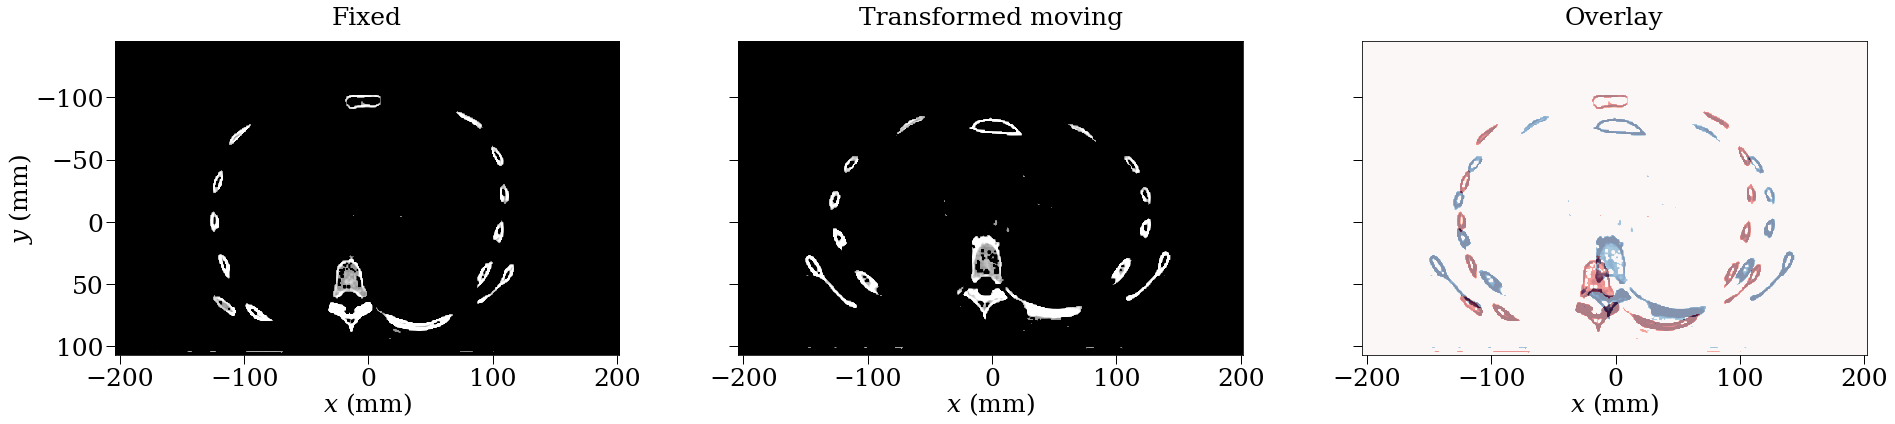

elastix: global - translation


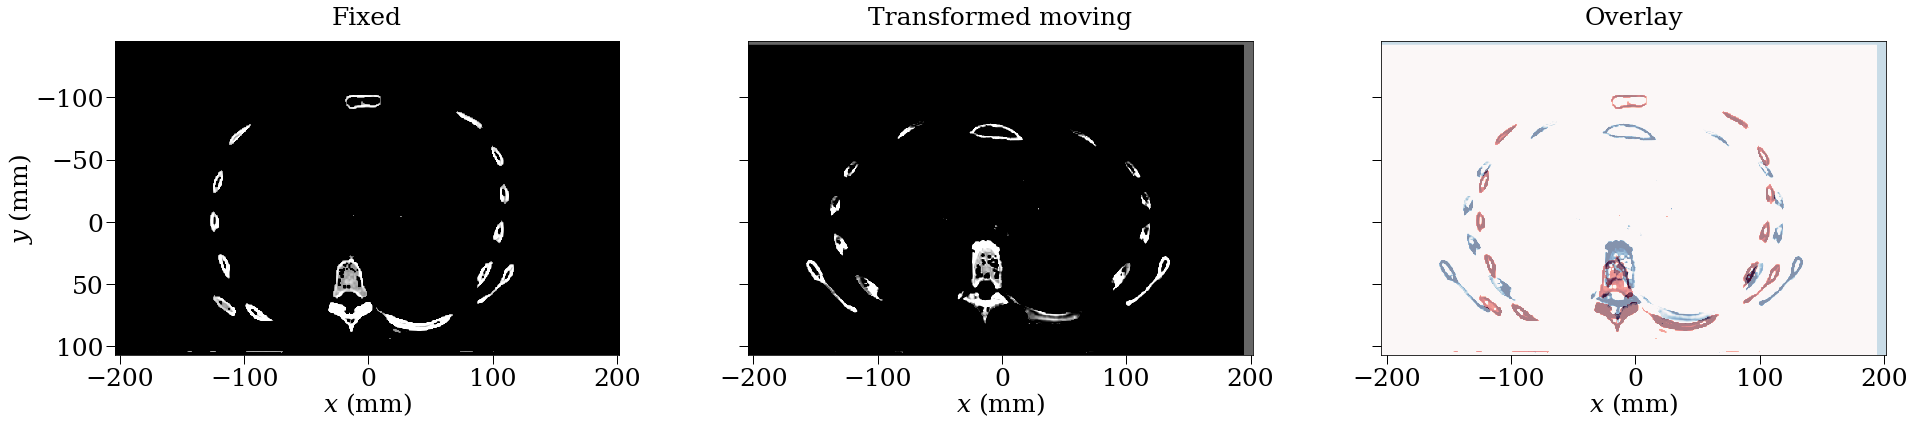

elastix: local (CTVn_IMN) - initial_alignment


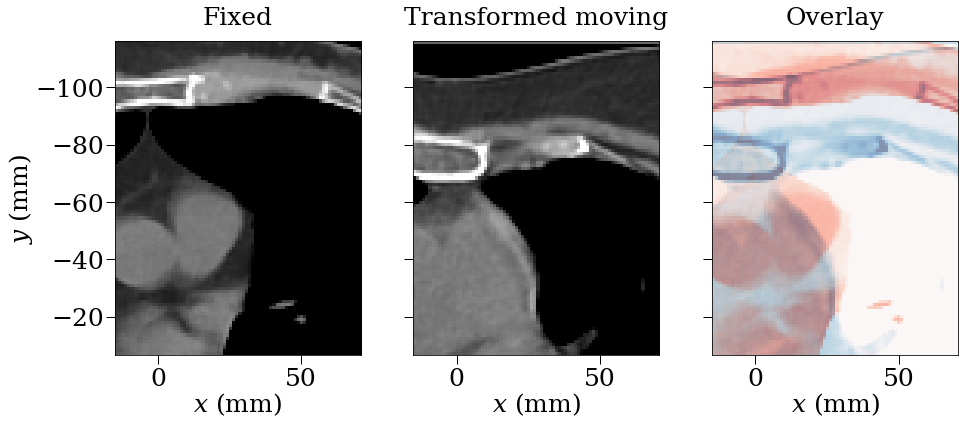

elastix: local (CTVn_IMN) - bspline


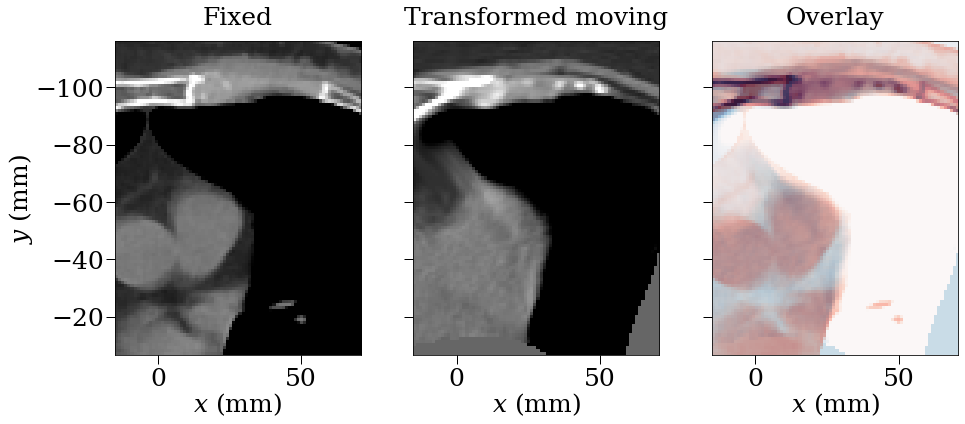

elastix: local (CTVp_4000) - initial_alignment


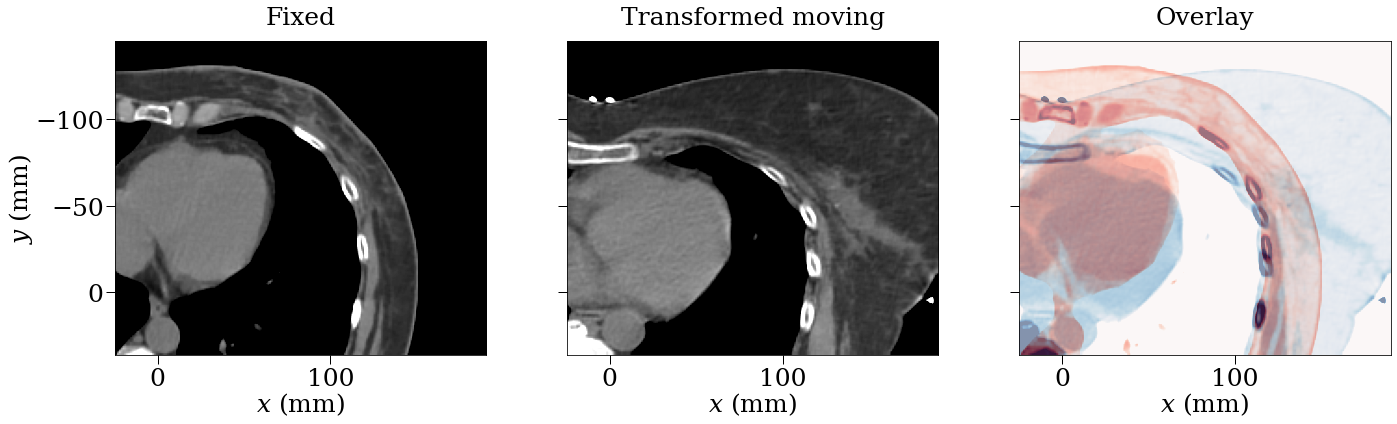

elastix: local (CTVp_4000) - bspline


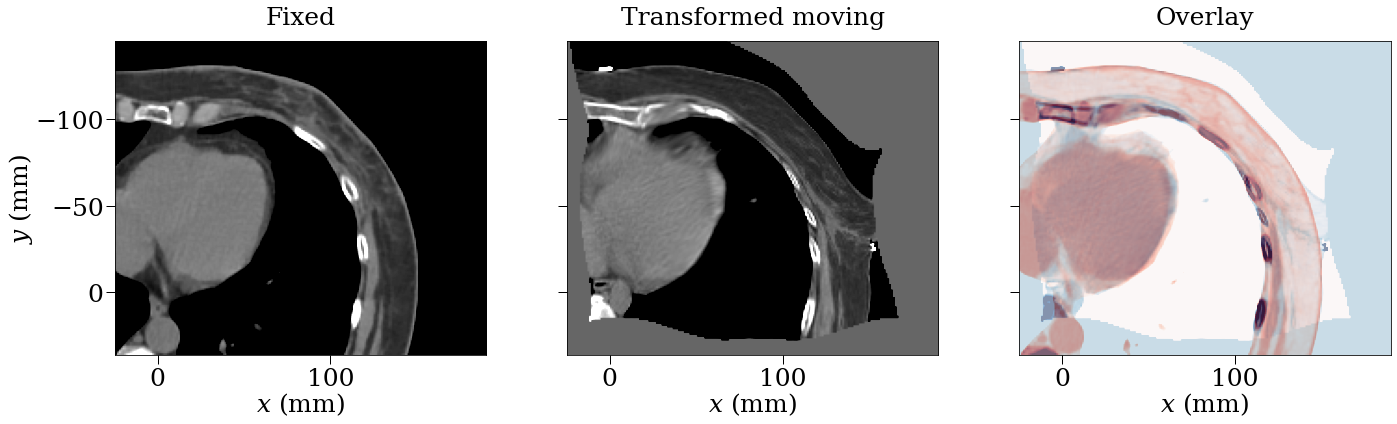

elastix: local (Contra_Breast) - initial_alignment


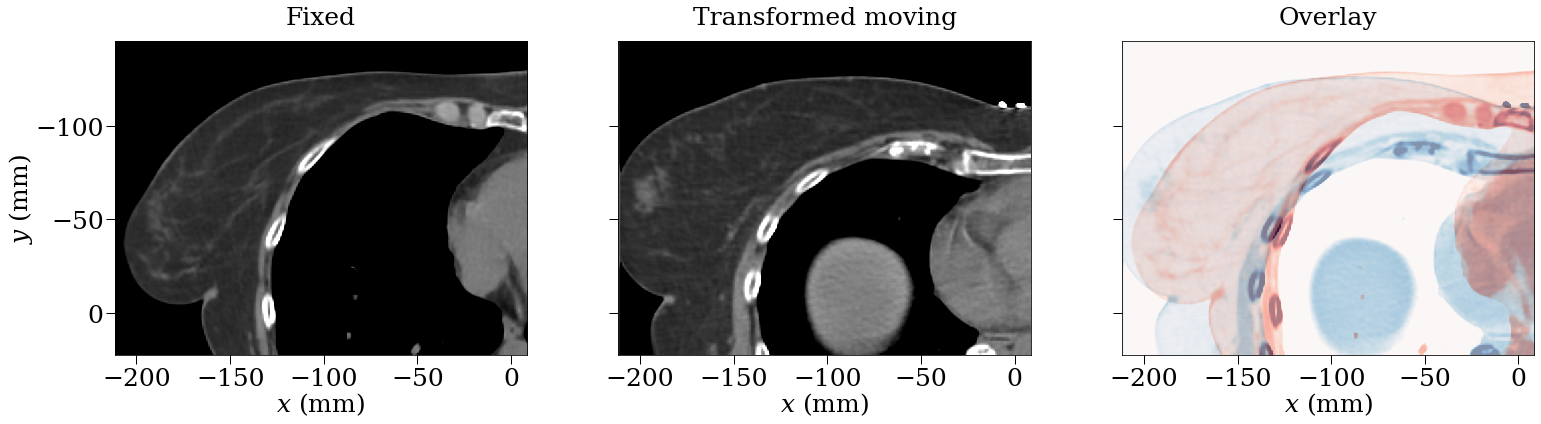

elastix: local (Contra_Breast) - bspline


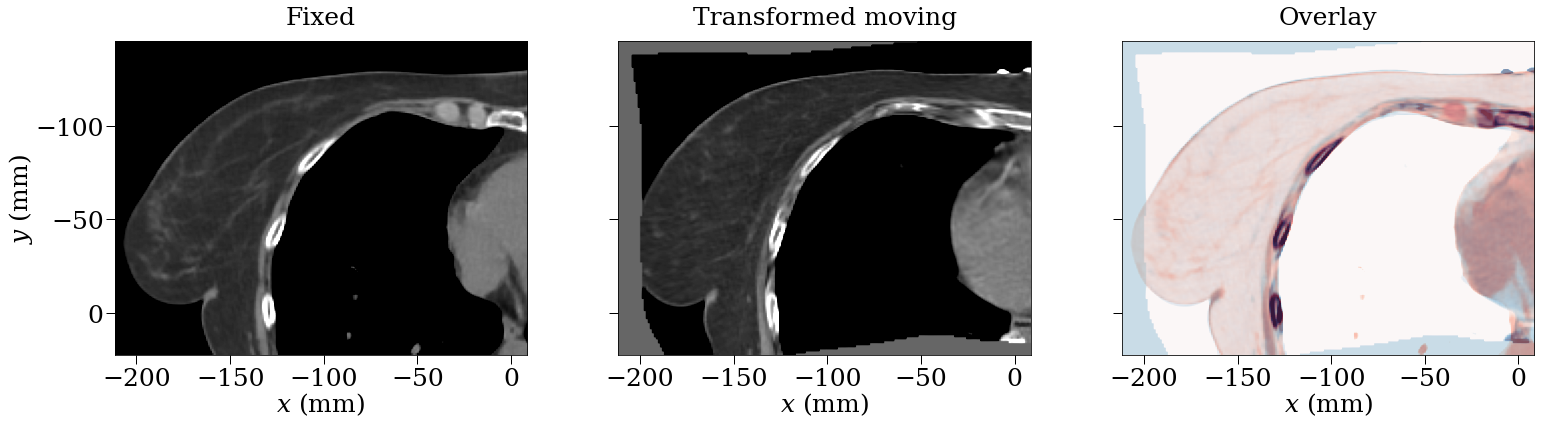

elastix: local (Heart) - initial_alignment


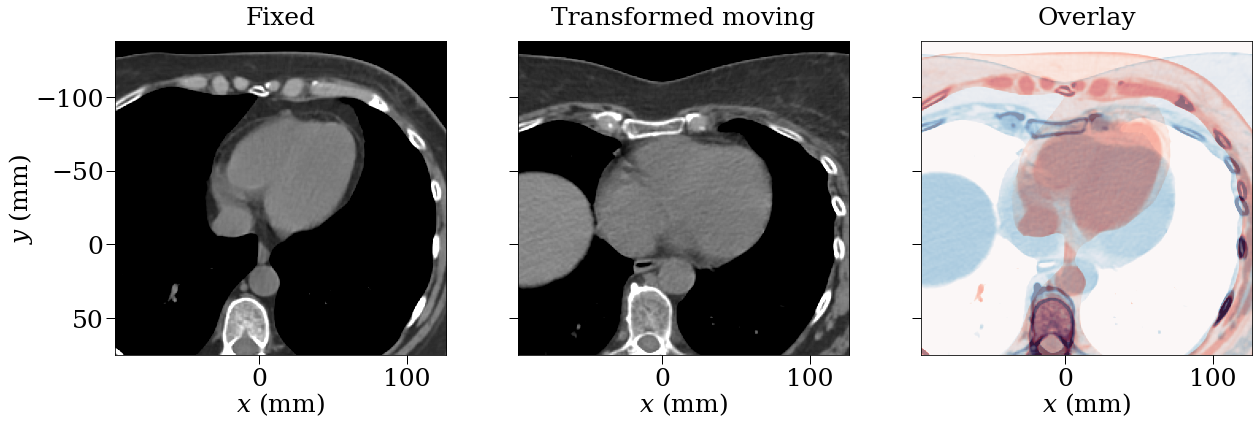

elastix: local (Heart) - bspline


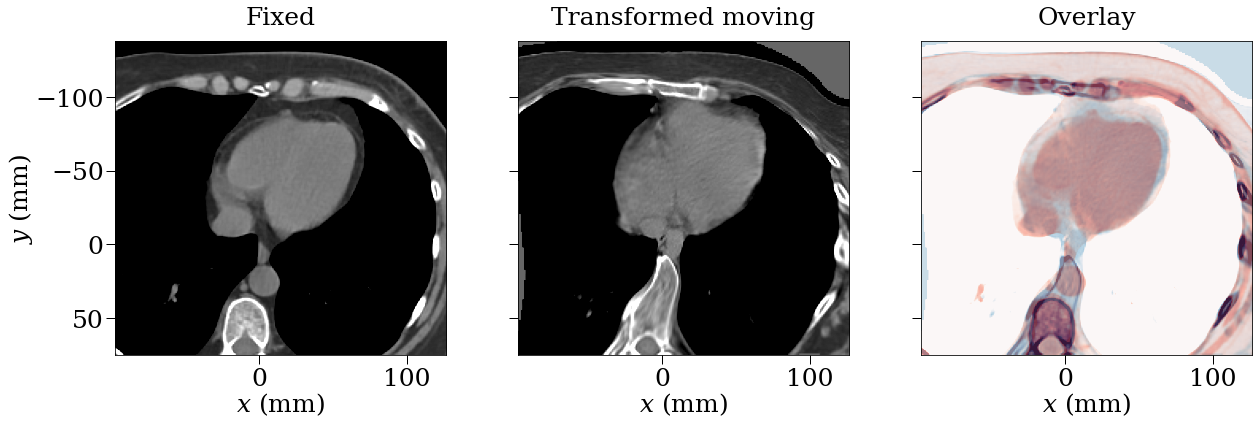

elastix: local (Ipsi_Lung) - initial_alignment


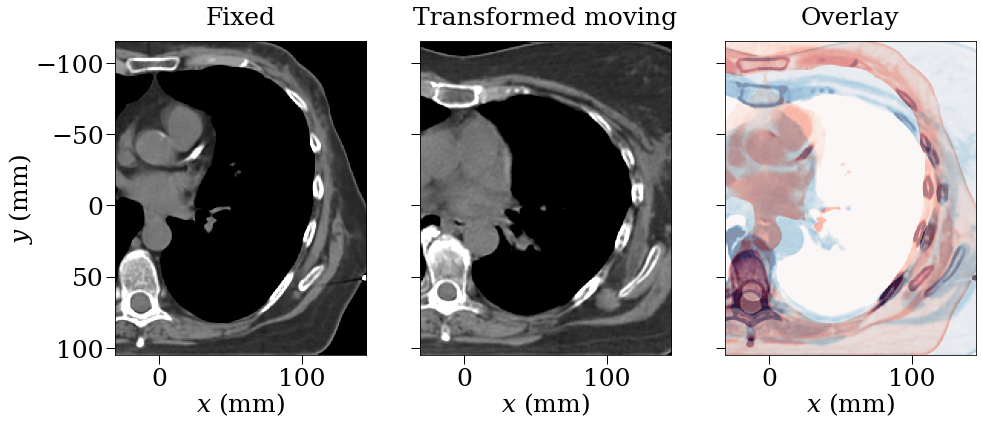

elastix: local (Ipsi_Lung) - bspline


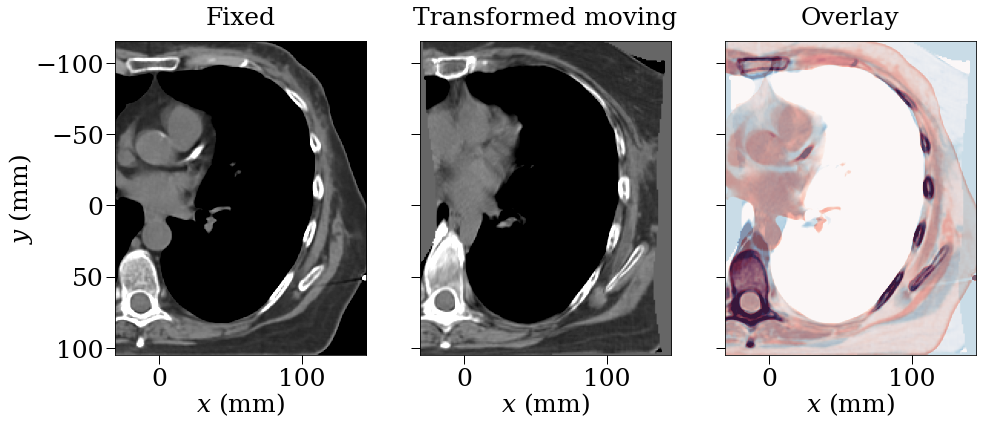

In [5]:
# Define atlas with which to compare.
atlas = atlases[1]
print(f"{test.id} vs {atlas.id}")

# Define ROI(s) for which to show results of local registration.
reg_roi_names = roi_names

# Show results at each step of registration.
sas = mas.get_sas(atlas.id)
for step in sas.get_auto_steps():
    for reg_roi_name in reg_roi_names:
        reg = sas.get_registration(step=step, roi_name=reg_roi_name)
        for reg_step in reg.steps:
            step_reg = f"{step} ({reg_roi_name})" if "local" == step else step
            print(f"{engine}: {step_reg} - {reg_step}")
            reg.view_result(reg_step)
        if "global" == step:
            break

## Segmentation results

The following compares the segmentations from the consensus result (red), and the manual segmentation of the target (gold).

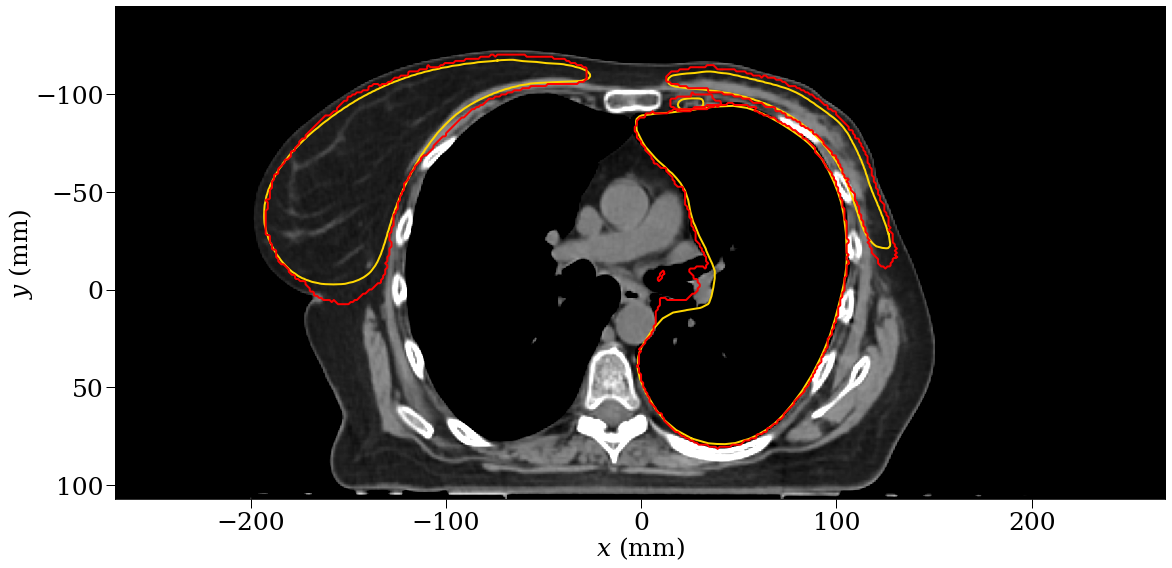

In [6]:
# Collect the atlas results in a single structure sets.
ss2_global = sum([mas.get_sas(idx).get_segmentation() for idx in mas.sass],
                 StructureSet())
for roi in ss2_global: roi.set_color("blue")

# Define structure set for the consensus result.
ss2_consensus = mas.get_consensus(consensus_type="staple")
for roi in ss2_consensus: roi.set_color("red")

# Set colour for the manual segmentation of the test.
ss1_filtered = mas.get_sas().ss1_filtered or StructureSet()
for roi in ss1_filtered: roi.set_color("gold")

# Collect together all structure sets, and set the image to be the test image.
#rois = ss1_filtered + ss2_global + ss2_consensus
rois = ss1_filtered + ss2_consensus
# rois = ss1_filtered + ss2_global + ss2_consensus
rois.set_image(mas.im1)

# Display results
mas.im1.view(rois=rois, legend=False, init_view="x-y",
             figsize=8, zoom=1);

The following summarises Dice scores for final atlas-based segmentations compared with manual segmentation.

In [7]:
df1 = mas.get_comparison(atlas_ids_to_compare=True, consensus_types="staple",
                         reg_steps=-1, metrics="dice", id1=test.id, decimal_places=2)
print(f"Test patient: {test.id}\n")
print(df1.drop(columns=["id1", "strategy", "step", "reg_step"]));

# Optionally save results to file.
# df1.to_csv("multiatlas.csv", index=False)

Test patient: ANON06

              ROI  dice                                        id2
0        CTVn_IMN  0.46                                     ANON02
1       CTVp_4000  0.63                                     ANON02
2   Contra_Breast  0.92                                     ANON02
3           Heart  0.84                                     ANON02
4       Ipsi_Lung  0.95                                     ANON02
5        CTVn_IMN  0.46                                     ANON05
6       CTVp_4000  0.77                                     ANON05
7   Contra_Breast  0.75                                     ANON05
8           Heart  0.91                                     ANON05
9       Ipsi_Lung  0.96                                     ANON05
10       CTVn_IMN  0.43                                     ANON03
11      CTVp_4000  0.70                                     ANON03
12  Contra_Breast  0.90                                     ANON03
13          Heart  0.84                 

## Heart dose

The following summarises different estimates of heart dose, and gives information on similarities between test image and atlas image.

Estimated mean heart doses include:

1. Test dose + test heart: planned mean dose for test patient.
2. Atlas dose + atlas heart: planned mean dose for atlas patient.
3. Translated atlas dose + consensus heart: mean dose for test patient,
   based on ROIs and dose fields of (all) atlas patients.


Test: ANON06; atlas: ANON01:

Test dose + test heart: 4.88
Test dose + consensus heart: 5.52
Test dose + mapped atlas heart: 5.90
Translated atlas dose + test heart: 9.15
Translated atlas dose + consensus heart: 11.63
Translated atlas dose + mapped atlas heart: 11.55
Deformed atlas dose + test heart: 3.96
Deformed atlas dose + consensus heart: 4.46
Deformed atlas dose + mapped atlas heart: 4.65
Atlas dose + atlas heart: 4.15

Registration: global

                dice
foreground  0.893375

                   dice
CTVn_IMN       0.117996
CTVp_4000      0.369901
Contra_Breast  0.558169
Heart          0.604260
Ipsi_Lung      0.710024



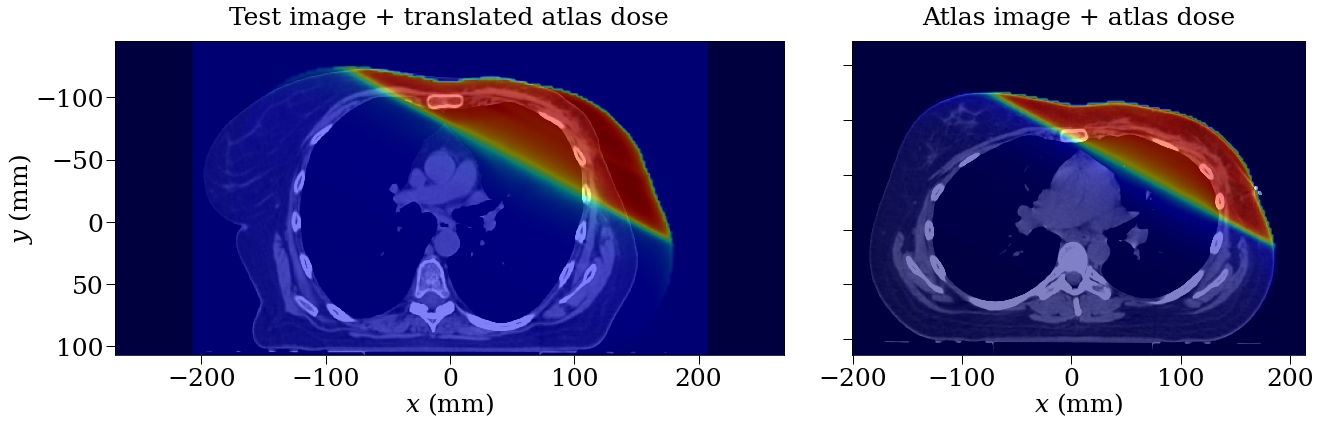


Registration: local

                   dice
CTVn_IMN       0.289758
CTVp_4000      0.720425
Contra_Breast  0.269164
Heart          0.899384
Ipsi_Lung      0.839465



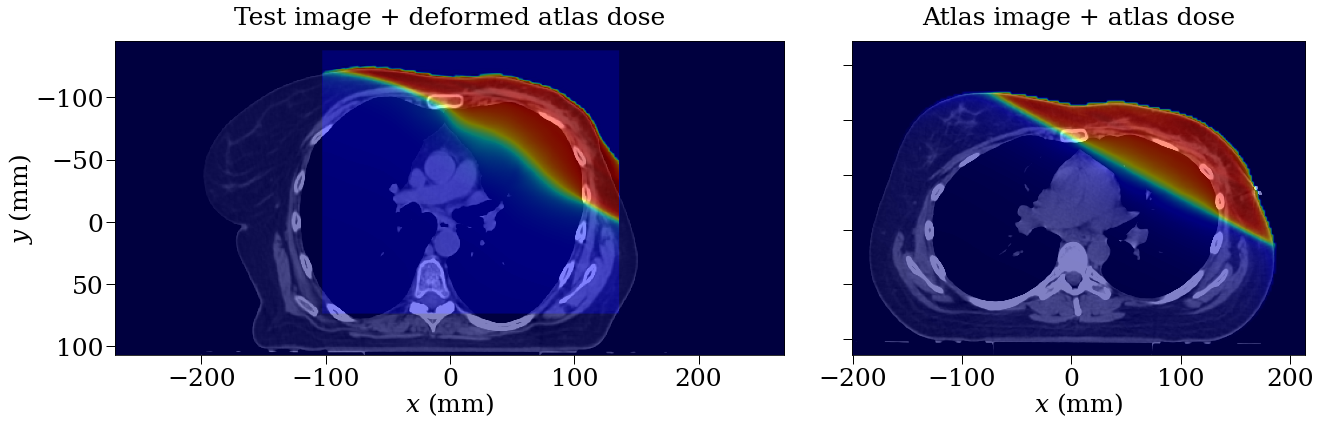


Test: ANON06; atlas: ANON02:

Test dose + test heart: 4.88
Test dose + consensus heart: 5.52
Test dose + mapped atlas heart: 5.62
Translated atlas dose + test heart: 10.46
Translated atlas dose + consensus heart: 12.57
Translated atlas dose + mapped atlas heart: 12.60
Deformed atlas dose + test heart: 4.19
Deformed atlas dose + consensus heart: 5.15
Deformed atlas dose + mapped atlas heart: 5.37
Atlas dose + atlas heart: 5.54

Registration: global

                dice
foreground  0.768556

                   dice
CTVn_IMN       0.000000
CTVp_4000      0.271616
Contra_Breast  0.616868
Heart          0.614562
Ipsi_Lung      0.767162



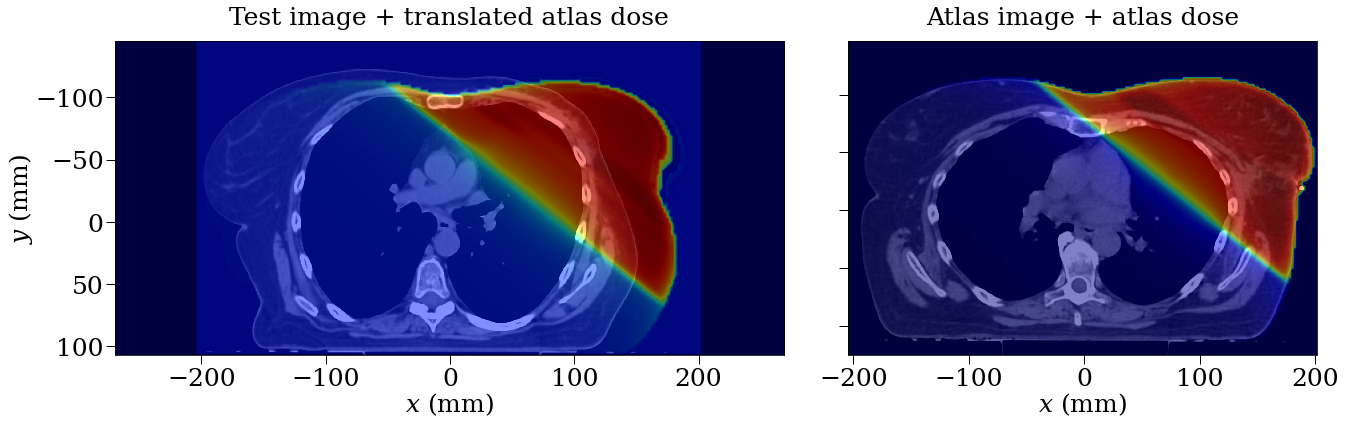


Registration: local

                   dice
CTVn_IMN       0.439050
CTVp_4000      0.720489
Contra_Breast  0.244509
Heart          0.925674
Ipsi_Lung      0.842892



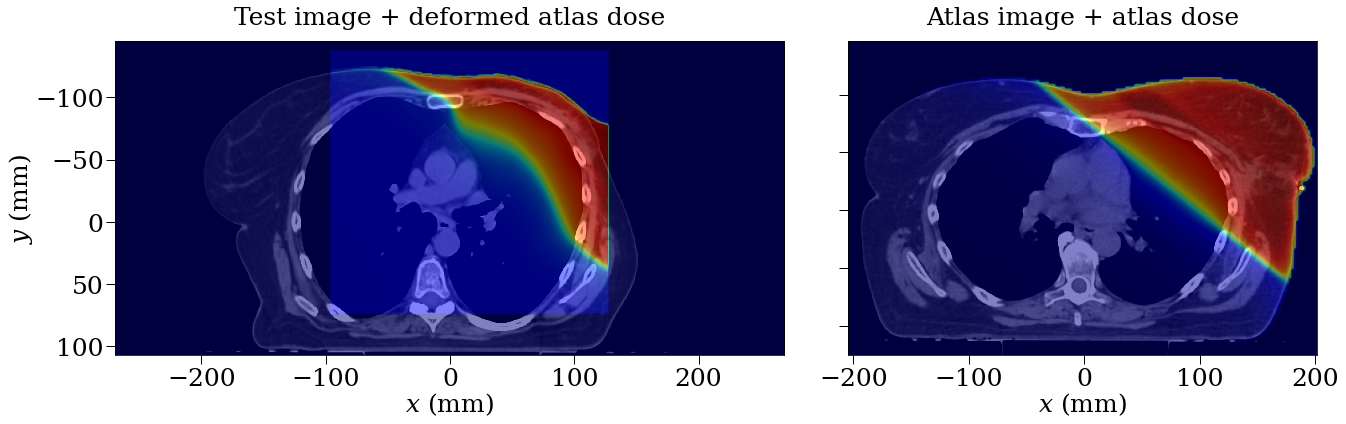


Test: ANON06; atlas: ANON03:

Test dose + test heart: 4.88
Test dose + consensus heart: 5.52
Test dose + mapped atlas heart: 4.94
Translated atlas dose + test heart: 10.85
Translated atlas dose + consensus heart: 14.30
Translated atlas dose + mapped atlas heart: 14.60
Deformed atlas dose + test heart: 2.32
Deformed atlas dose + consensus heart: 3.45
Deformed atlas dose + mapped atlas heart: 3.16
Atlas dose + atlas heart: 2.71

Registration: global

                dice
foreground  0.866585

                   dice
CTVn_IMN       0.000000
CTVp_4000      0.112013
Contra_Breast  0.477374
Heart          0.382230
Ipsi_Lung      0.701314



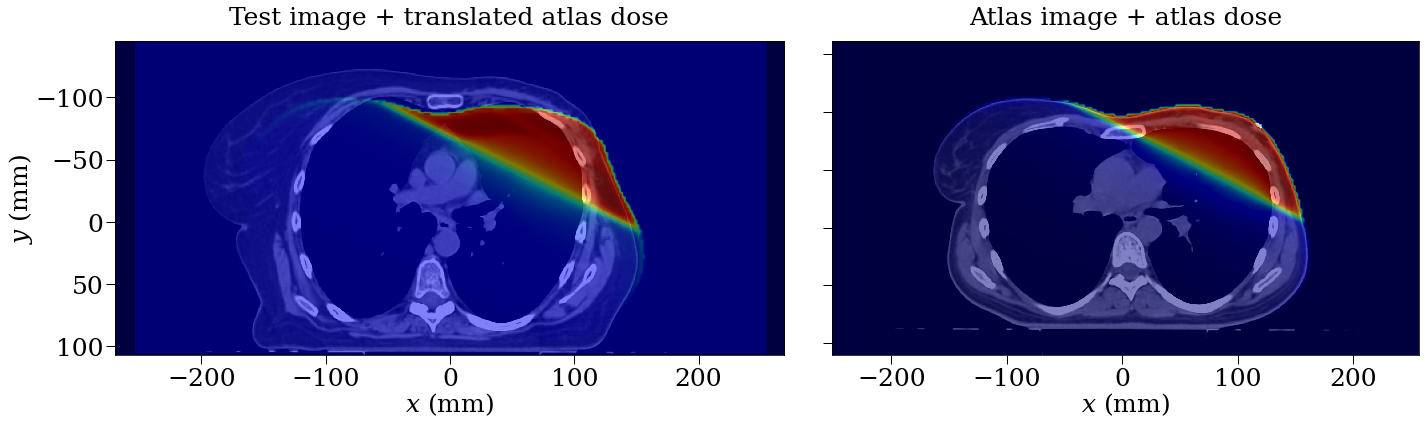


Registration: local

                   dice
CTVn_IMN       0.350207
CTVp_4000      0.566522
Contra_Breast  0.172706
Heart          0.911445
Ipsi_Lung      0.675623



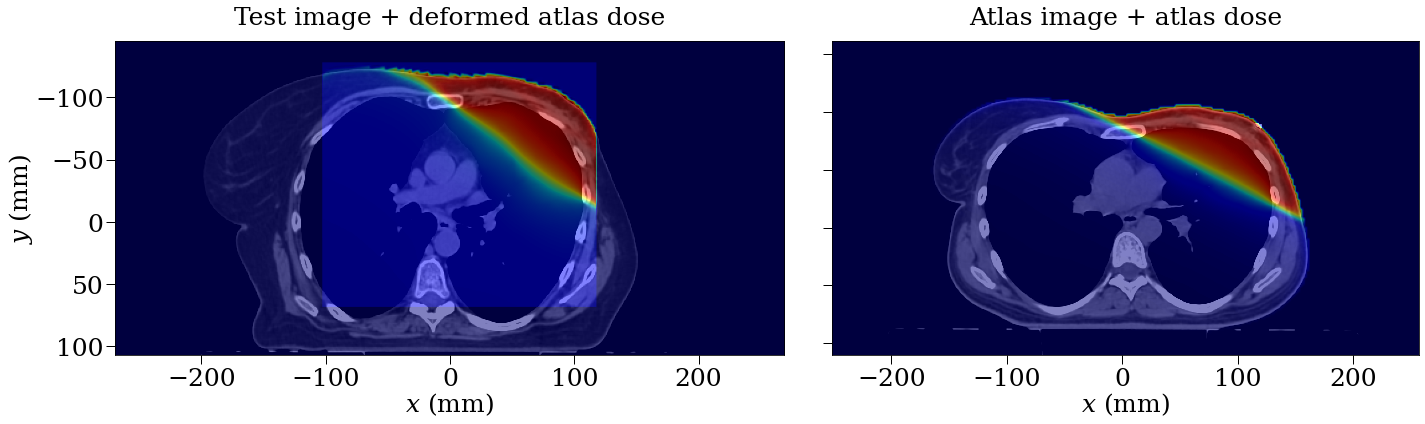


Test: ANON06; atlas: ANON04:

Test dose + test heart: 4.88
Test dose + consensus heart: 5.52
Test dose + mapped atlas heart: 6.20
Translated atlas dose + test heart: 11.89
Translated atlas dose + consensus heart: 12.21
Translated atlas dose + mapped atlas heart: 12.33
Deformed atlas dose + test heart: 2.00
Deformed atlas dose + consensus heart: 2.13
Deformed atlas dose + mapped atlas heart: 2.21
Atlas dose + atlas heart: 2.29

Registration: global

               dice
foreground  0.75185

                   dice
CTVn_IMN       0.164820
CTVp_4000      0.156115
Contra_Breast  0.042545
Heart          0.540161
Ipsi_Lung      0.789668



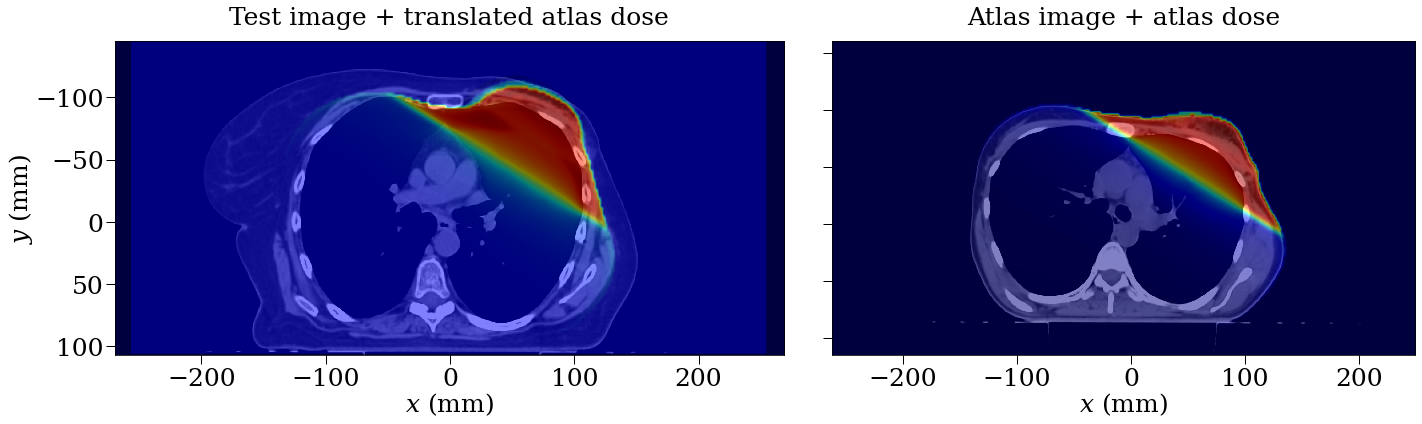


Registration: local

                   dice
CTVn_IMN       0.214128
CTVp_4000      0.492696
Contra_Breast  0.151946
Heart          0.897336
Ipsi_Lung      0.642586



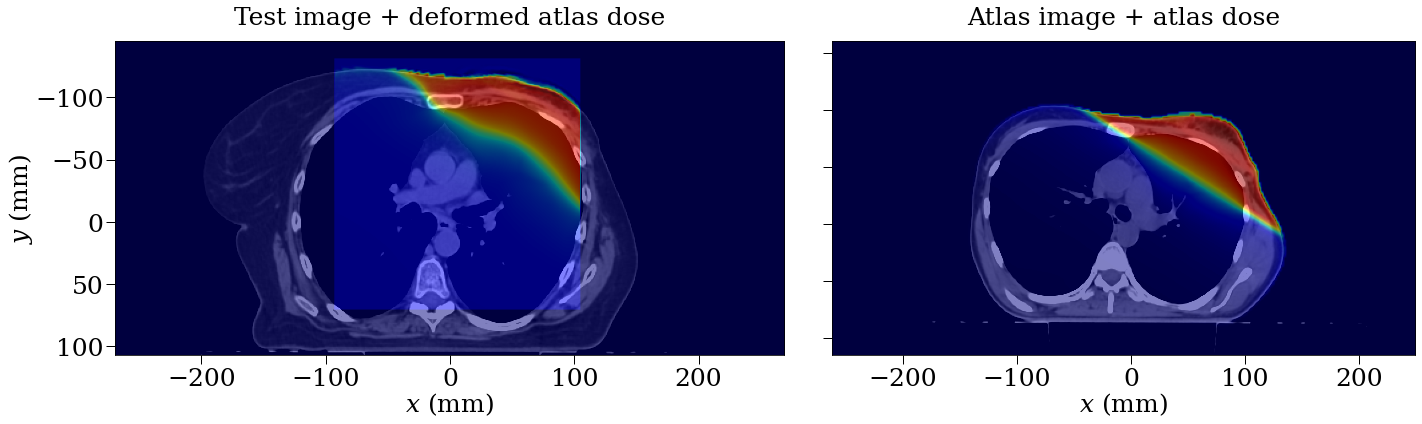


Test: ANON06; atlas: ANON05:

Test dose + test heart: 4.88
Test dose + consensus heart: 5.52
Test dose + mapped atlas heart: 4.69
Translated atlas dose + test heart: 5.33
Translated atlas dose + consensus heart: 6.86
Translated atlas dose + mapped atlas heart: 5.09
Deformed atlas dose + test heart: 2.02
Deformed atlas dose + consensus heart: 2.61
Deformed atlas dose + mapped atlas heart: 1.99
Atlas dose + atlas heart: 1.78

Registration: global

                dice
foreground  0.708151

                   dice
CTVn_IMN       0.226150
CTVp_4000      0.320459
Contra_Breast  0.625060
Heart          0.597980
Ipsi_Lung      0.763570



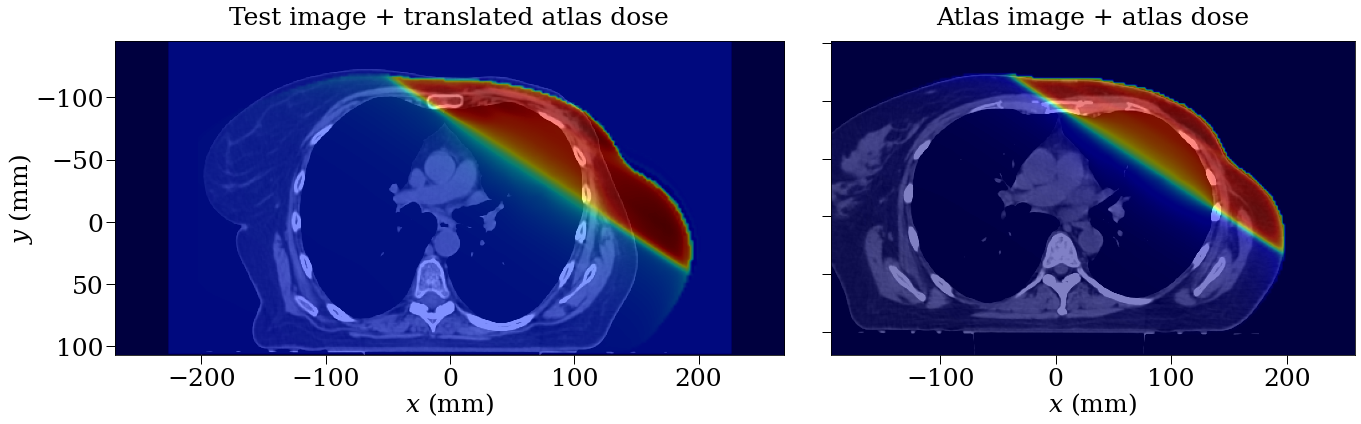


Registration: local

                   dice
CTVn_IMN       0.335506
CTVp_4000      0.682023
Contra_Breast  0.283763
Heart          0.828885
Ipsi_Lung      0.813634



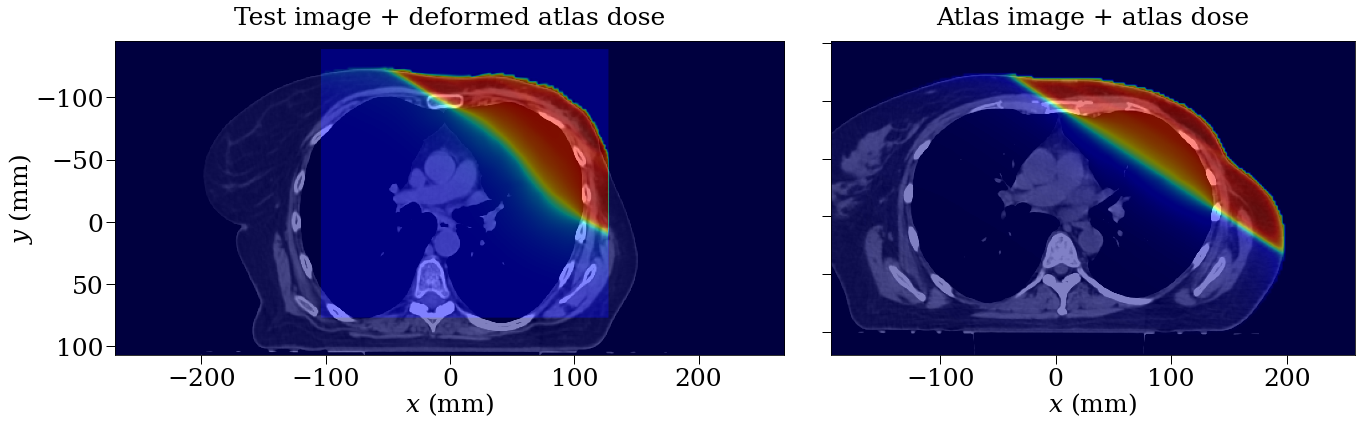

In [8]:
test_dose = test.dose.clone()
test_dose.match_size(mas.im1)
test_mean_dose = test_dose.get_mean_dose(test.structure_set["Heart"])
test_foreground = mas.im1.get_foreground_roi()

for atlas in atlases:
    sas = mas.get_sas(atlas.id)
    reg_global = sas.get_registration(step="global")
    atlas_translated_dose = reg_global.transform(atlas.dose).astype("dcm")
    atlas_translated_dose.match_size(mas.im1)
    reg_local = sas.get_registration(step="local", roi_name="Heart")
    atlas_deformed_dose = reg_local.transform(atlas.dose).astype("dcm")
    atlas_deformed_dose.match_size(mas.im1)
    
    print(f"\nTest: {test.id}; atlas: {atlas.id}:\n")
    print(f"Test dose + test heart: {test_mean_dose:.2f}")
    print("Test dose + consensus heart: "
          f"{test_dose.get_mean_dose(ss2_consensus['Heart']):.2f}")
    print("Test dose + mapped atlas heart: "
          f"{test_dose.get_mean_dose(mas.get_sas(atlas.id).get_segmentation()['Heart']):.2f}")
    print("Translated atlas dose + test heart: "
          f"{atlas_translated_dose.get_mean_dose(test.structure_set['Heart']):.2f}")
    print("Translated atlas dose + consensus heart: "
          f"{atlas_translated_dose.get_mean_dose(ss2_consensus['Heart']):.2f}")
    print("Translated atlas dose + mapped atlas heart: "
          f"{atlas_translated_dose.get_mean_dose(mas.get_sas(atlas.id).get_segmentation()['Heart']):.2f}")
    print("Deformed atlas dose + test heart: "
          f"{atlas_deformed_dose.get_mean_dose(test.structure_set['Heart']):.2f}")
    print("Deformed atlas dose + consensus heart: "
          f"{atlas_deformed_dose.get_mean_dose(ss2_consensus['Heart']):.2f}")
    print("Deformed atlas dose + mapped atlas heart: "
          f"{atlas_deformed_dose.get_mean_dose(mas.get_sas(atlas.id).get_segmentation()['Heart']):.2f}")
    print("Atlas dose + atlas heart: "
          f"{atlas.dose.get_mean_dose(atlas.structure_set['Heart']):.2f}")
          
    for step in sas.get_auto_steps():
        reg = sas.get_registration(step=step, roi_name="Heart")
        print(f"\nRegistration: {step}\n")
        atlas_ct = reg.transform(mas.im2[atlas.id]).astype("dcm")
        atlas_ct.match_size(mas.im1)
        
        if "global" == step:
            atlas_foreground = atlas_ct.get_foreground_roi()
            print(test_foreground.get_comparison(atlas_foreground, metrics=["dice"], voxel_size=None))
            print()

        atlas_ss = reg.transform(atlas.structure_set)
        atlas_ss.set_image(mas.im1)
        print(ss2_consensus.get_comparison(atlas_ss, metrics=["dice"], voxel_size=None))
        print()
        
        if "global"  == step:
            atlas_dose = atlas_translated_dose
            title1 = "Test image + translated atlas dose"
        else:
            atlas_dose = atlas_deformed_dose
            title1 = "Test image + deformed atlas dose"
        title2 = "Atlas image + atlas dose"
        
        mas.im1.view(images=atlas.ct, dose=[atlas_dose, atlas.dose], title=[title1, title2])